# Identifying Duplicate Questions

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on [Quora](https://www.quora.com/), a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

If you have any questions or want to discuss competitions/hardware/games/anything with other Kagglers, then join the KaggleNoobs Slack channel [here](https://goo.gl/gGWFXe). We also have regular AMAs with top Kagglers there.

**And as always, if this helped you, some upvotes would be very much appreciated - that's where I get my motivation! :D**

Let's dive right into the data!

In [10]:
from __future__ import division


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('./anlpir18_data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./anlpir18_data/' + f) / 1000000, 2)) + 'MB')

# File sizes
train.only-es.tsv             2.33MB
test.tsv                      0.19MB
test.only-en.tsv              0.18MB
cikm_spanish_train_20180516.only-en.qid.tsv0.18MB
train.only-en.tsv             2.09MB
train.tsv                     4.43MB


Looks like we are simply given two files this time round, one for the training set and one for the test set. They are relatively small compared to other recent competitions, weighing in at less than 400MB total.

It's worth noting that there is a lot more testing data than training data. This could be a sign that some of the test data is dummy data designed to deter hand-labelling, and not included in the calculations, like we recently saw in the [DSTL competition](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/leaderboard).

Let's open up one of the datasets.

## Training set

In [11]:
#df_train = pd.read_csv('./anlpir18_data/train.tsv', sep='\t', encoding="utf8")
df_train = pd.read_csv('./anlpir18_data/train.only-en.tsv', sep='\t', encoding="utf8") #  only english text
df_train.head()

# rewrite: è -> e
#df_train.question1 = df_train["question1"].str.replace(u'\xe9', 'e')
#df_train.question2 = df_train["question2"].str.replace(u'\xe9', 'e')

,pid,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,"hello, i click in product received",I bought a product and have not received a con...,0
1,3,5,6,"Hello! I have closed the dispute on may 21, 20...",I did not get refund of my money. Two months h...,0
2,5,9,10,l ordered from spain to spain now they send th...,My order came but color different from that I ...,0
3,7,13,14,Do I need to pay custom duty,How to pay customs duty,1
4,9,17,18,I didn't receive my order?,"My order shows that I have not paid, but I did",0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 20000
Duplicate pairs: 25.47%
Total number of questions in the training data: 7563
Number of questions that appear multiple times: 6371
()


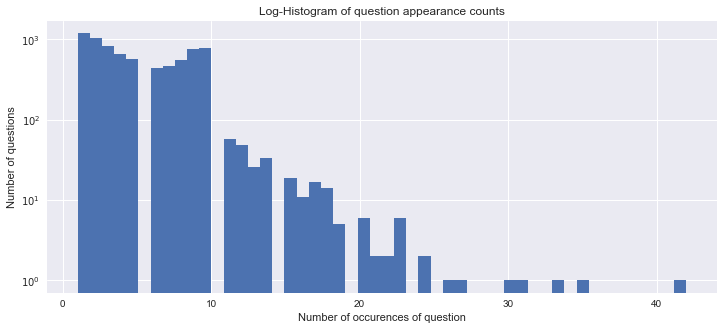

In [12]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In terms of questions, everything looks as I would expect here. Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

We can see that we have a 37% positive class in this dataset. Since we are using the [LogLoss](https://www.kaggle.com/wiki/LogarithmicLoss) metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.

## Test Submission

In [13]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

#print df_train[df_train.is_duplicate == 1].count()
#print df_train[df_train.is_duplicate == 0].count()

#print df_train.count()

#df_test = pd.read_csv('./anlpir18_data/test.tsv', sep='\t', encoding="utf8")
df_test = pd.read_csv('./anlpir18_data/test.only-en.tsv', sep='\t', encoding="utf8") # only english test

# rewrite: è -> e
#df_test.question1 = df_test["question1"].str.replace(u'\xe9', 'e')
#df_test.question2 = df_test["question2"].str.replace(u'\xe9', 'e')

print('Predicted score:', log_loss(df_test['is_duplicate'], np.zeros_like(df_test['is_duplicate']) + p))



#sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
#sub.to_csv('naive_submission.csv', index=False)
#sub.head()

('Predicted score:', 0.5674399591375886)
('Predicted score:', 0.45425659419418002)


**0.55 on the leaderboard! Score!**

However, not all is well. The discrepancy between our local score and the LB one indicates that the distribution of values on the leaderboard is very different to what we have here, which could cause problems with validation later on in the competition.

According to this [excellent notebook by David Thaler](www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb/notebook), using our score and submission we can calculate that we have about 16.5% positives in the test set. This is quite surprising to see, so it'll be something that will need to be taken into account in machine learning models.

Next, I'll take a quick peek at the statistics of the test data before we look at the text itself.

## Test Set

In [14]:
#df_test = pd.read_csv('./anlpir18_data/test.tsv', sep='\t', encoding="utf8")
df_test.head()

,pid,qid1,qid2,question1,question2,is_duplicate
0,39394,14972,14973,"I have not been able to pay with my card, what...",I can not pay for my order with my card.,1
1,39396,14975,14976,"Why does it appear ""not paid"" when the payment...","I paid by bank transfer, but the payment has n...",0
2,39398,14979,14980,When will I receive my refund if I pay by cred...,When will I receive the refund if I cancel my ...,0
3,39400,14983,14984,What will happen after opening a dispute?,What will happen after I have sent my Warranty...,0
4,39402,14987,14988,The product I received does not correspond wit...,I received a product that does not work.,0


In [15]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 1400


Nothing out of the ordinary here. We are once again given rowIDs and the textual data of the two questions. It is worth noting that we are not given question IDs here however for the two questions in the pair.

It is also worth pointing out that the actual number of test rows are likely to be much lower than 2.3 million. According to the [data page](https://www.kaggle.com/c/quora-question-pairs/data), most of the rows in the test set are using auto-generated questions to pad out the dataset, and deter any hand-labelling. This means that the true number of rows that are scored could be very low.

We can actually see in the head of the test data that some of the questions are obviously auto-generated, as we get delights such as "How their can I start reading?" and "What foods fibre?". Truly insightful questions.

Now onto the good stuff - the text data!
## Text analysis

First off, some quick histograms to understand what we're looking at. **Most analysis here will be only on the training set, to avoid the auto-generated questions**

mean-train 42.39 std-train 31.02 mean-test 53.25 std-test 29.65 max-train 256.00 max-test 274.00


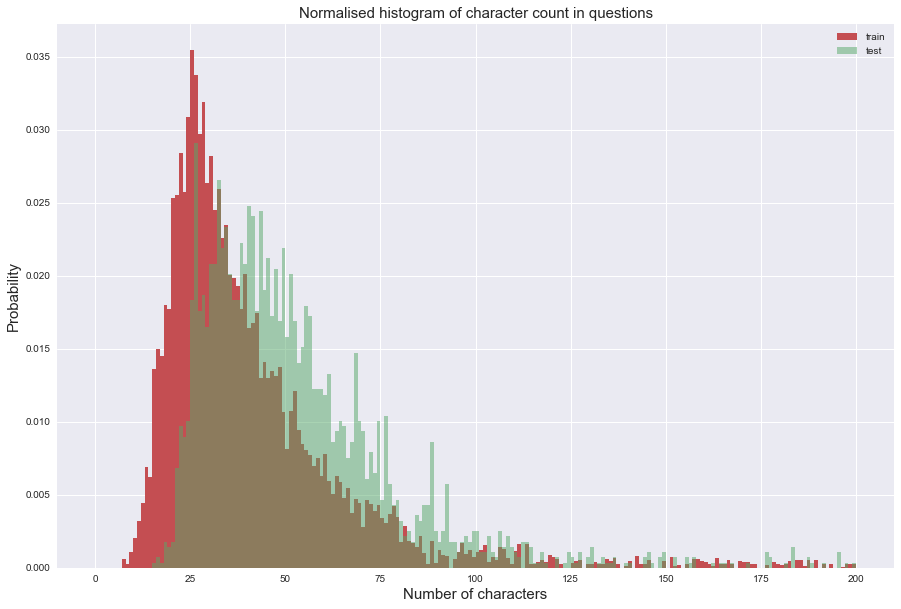

In [16]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(unicode)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(unicode)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 8.67 std-train 6.15 mean-test 10.86 std-test 5.97 max-train 56.00 max-test 58.00


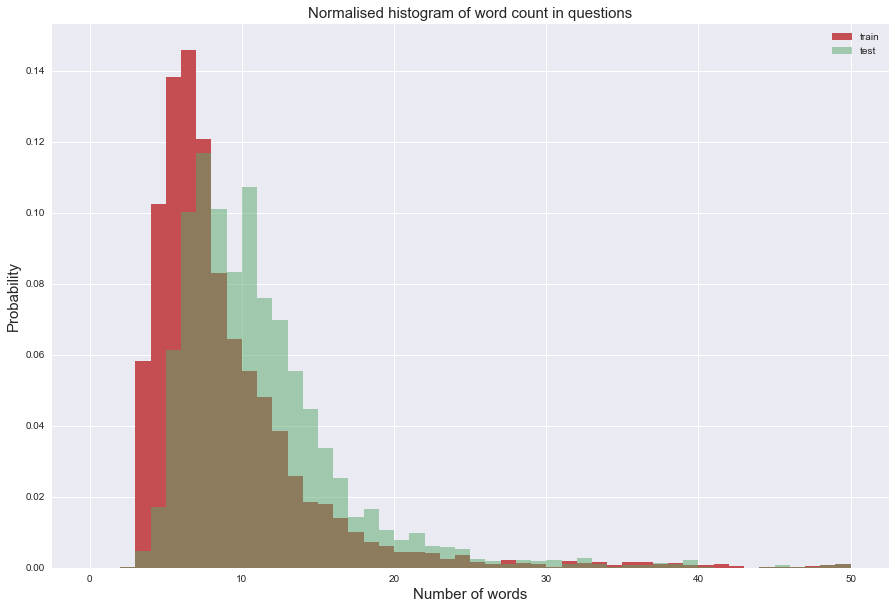

In [17]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

(-0.5, 1439.5, 1079.5, -0.5)

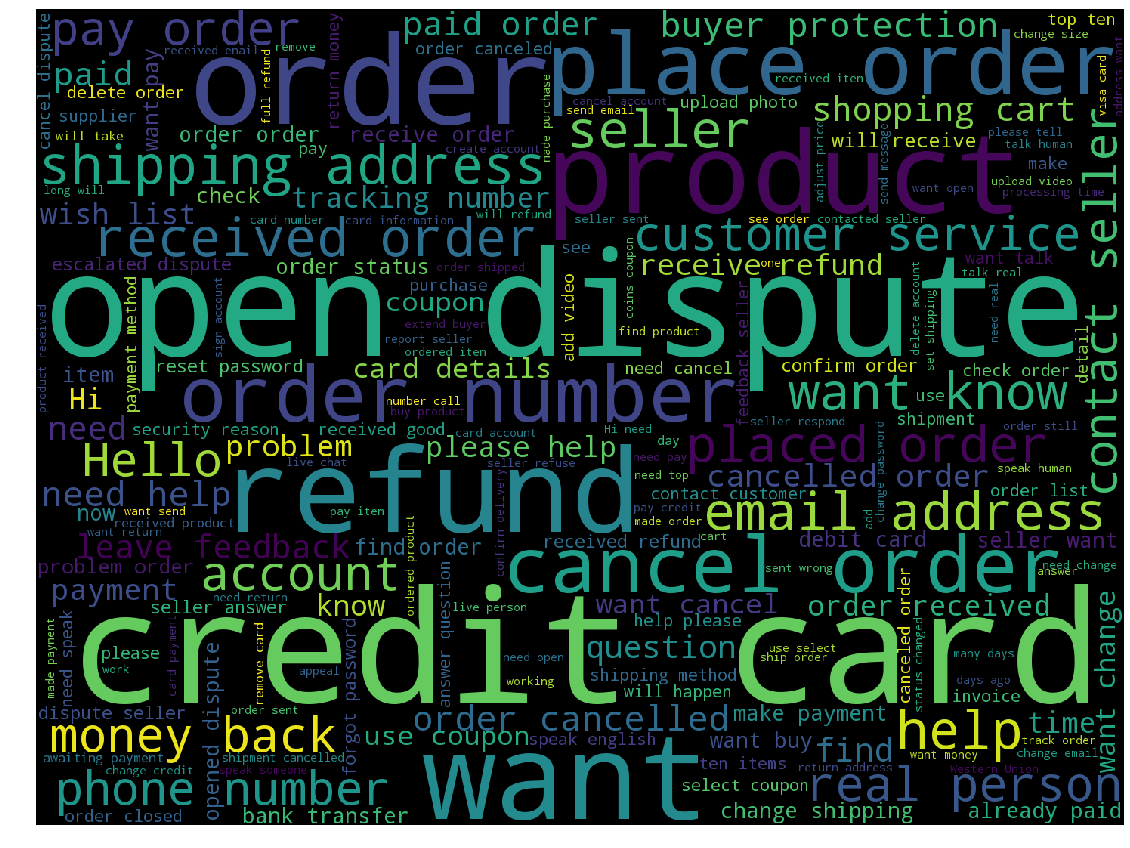

In [18]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(unicode)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [204]:
df = pd.concat([df_train, df_test])

x = pd.DataFrame()

x['len_q1'] = df['question1'].apply(lambda x: len(unicode(x)))
x['len_q2'] = df['question2'].apply(lambda x: len(unicode(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['len_char_q1'] = df['question1'].apply(lambda x: len(unicode(x).replace(' ', '')))
x['len_char_q2'] = df['question2'].apply(lambda x: len(unicode(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['question1'].apply(lambda x: len(unicode(x).split()))
x['len_word_q2'] = df['question2'].apply(lambda x: len(unicode(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

"""
x['similarity'] = df['word_shares'].apply(lambda x: float(x.split(':')[5]))
"""

print "x.shape:", x.shape

from sklearn.metrics import roc_auc_score
for col_name in set(x.columns):
    print "%14s AUC: %3.2f" % (col_name, roc_auc_score(df_train["is_duplicate"], x[:df_train.shape[0]].ix[:, col_name]))

x.shape: (21400, 14)
  exactly_same AUC: 0.50
   len_char_q2 AUC: 0.40
   len_char_q1 AUC: 0.41
avg_world_len2 AUC: 0.45
      diff_len AUC: 0.49
avg_world_len1 AUC: 0.48
   len_word_q2 AUC: 0.42
   len_word_q1 AUC: 0.42
 diff_len_char AUC: 0.49
 diff_avg_word AUC: 0.52
    duplicated AUC: 0.50
        len_q1 AUC: 0.41
 diff_len_word AUC: 0.48
        len_q2 AUC: 0.40


In [20]:
def get_last_word(s):
    return unicode(s).split()[-1]

def get_len_chrs(s):
    res = -1
    try:
        res = len(set(list(s)))
    except:
        pass
    finally:
        return res
    
def get_set_chrs(s):
    res = set()
    try:
        res = set(list(x))
    except:
        pass
    finally:
        return res

In [21]:
df['q1_last_word1'] = df.question1.map(lambda x: get_last_word(x))
df['q2_last_word2'] = df.question2.map(lambda x: get_last_word(x))

In [22]:
df.tail()

,pid,qid1,qid2,question1,question2,is_duplicate,q1_last_word1,q2_last_word2
1395,42183,19205,19206,Do you want to know if you are sending batteri...,I would like to know if they accept American E...,0,Brazil?,Express.
1396,42185,19209,19210,my order is missing the small handle,I received the message that some products were...,0,handle,payment.
1397,42187,19213,17715,what mail can I send my disputes,I can not track my products with the code that...,0,disputes,me.
1398,42189,19213,12227,what mail can I send my disputes,How can I pay for my purchases?,0,disputes,purchases?
1399,42191,19215,15764,I opened a good dispute that I think,How to cancel a dispute?,0,think,dispute?


In [23]:
# TODO: add similarity score, not only binary one
# x['last_word_match'] = raw_df.apply(lambda r: r['q1_last_word1'] == r['q2_last_word2'])
#x['last_word_match'] = np.where((df['q1_last_word1'] == df['q2_last_word2']),1, 0)

In [24]:
######################
# New features 11.05 #
######################

# Shared characters 
x['chrs1_len'] = df.question1.map(lambda x: get_len_chrs(x))
x['chrs2_len'] = df.question2.map(lambda x: get_len_chrs(x))

chrs_common = []
for i, r in df.iterrows():
    try:
        set1 = set(r['question1'])
        set2 = set(r['question2'])
        chrs_common.append(len(set1.intersection(set2)))
    except:
        chrs_common.append(-1)
#x['chrs_common_len'] = chrs_common

## Semantic Analysis

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [25]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 32.97%
Questions with [math] tags: 0.00%
Questions with full stops: 13.73%
Questions with capitalised first letters: 63.50%
Questions with capital letters: 69.34%
Questions with numbers: 3.27%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

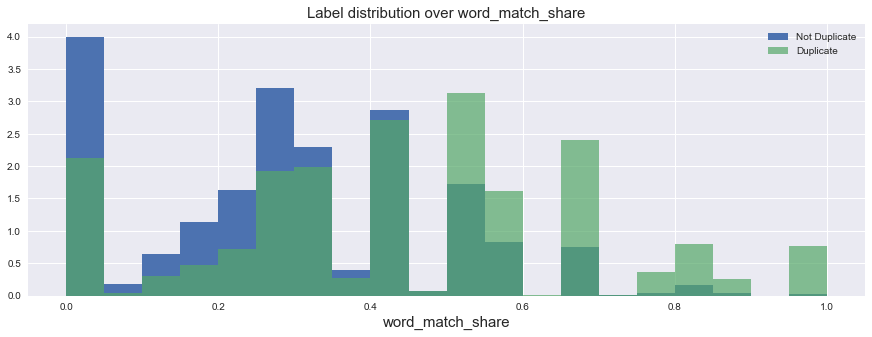

In [26]:
from nltk.corpus import stopwords

#stops = set(stopwords.words("english"))
#stops = set(stopwords.words("spanish"))
stops = set(stopwords.words("english")) | set(stopwords.words("spanish"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in unicode(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in unicode(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/ float(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [27]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / float(count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [28]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[(u'i', 2.5694390914463372e-05), (u'to', 4.073485681697829e-05), (u'my', 4.3546420484236195e-05), (u'the', 4.638003803163119e-05), (u'how', 5.22384161312229e-05), (u'a', 5.813277525869085e-05), (u'can', 5.942829975634397e-05), (u'not', 6.059504332545598e-05), (u'order', 6.16827041697508e-05), (u'do', 6.498992656138298e-05)]

Least common words and weights: 


[(u'update?', 9.998000399920016e-05),
 (u'larger?', 9.998000399920016e-05),
 (u'expired!', 9.998000399920016e-05),
 (u'null?', 9.998000399920016e-05),
 (u'atef', 9.998000399920016e-05),
 (u'error,', 9.998000399920016e-05),
 (u'company,', 9.998000399920016e-05),
 (u'cancellation?', 9.998000399920016e-05),
 (u'offline?', 9.998000399920016e-05),
 (u'validated', 9.998000399920016e-05)]

In [29]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in unicode(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in unicode(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / float(np.sum(total_weights))
    return R

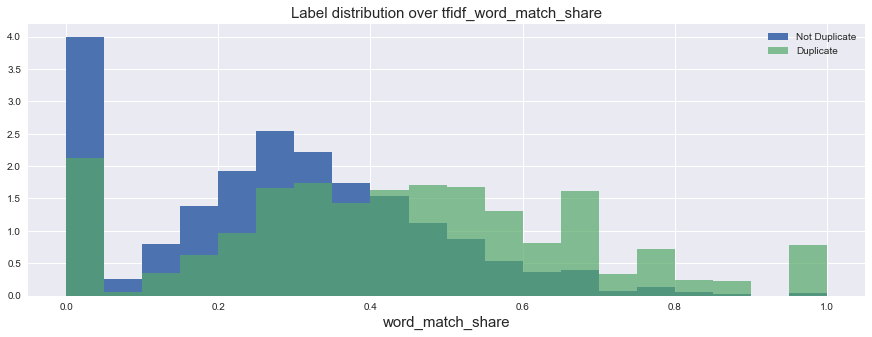

In [30]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [31]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

('Original AUC:', 0.6869002363772535)
('   TFIDF AUC:', 0.68853174040635012)


So it looks like our TF-IDF actually got _worse_ in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.


The Jaccard containment is a measure of set containment. A high index value (b) tells that the two sets are perfect set and subset
<img src="https://www.researchgate.net/profile/Nazar_Zaki/publication/260446449/figure/fig2/AS:267672290066477@1440829455864/An-example-of-similarity-and-containment-metrics-The-Jaccard-and-Geometric-indexes-are.png" width="50%"/>

In [32]:
from string import punctuation


punctuation = unicode(punctuation) + u'¿'
print repr(punctuation)
print punctuation


def word_jaccard_containment(row, left=True, n=1):
    # left ==True: Compute containment of left question into the right one
    # right==True: Compute containment of right question into the left one
    q1words = {}
    q2words = {}
    
    table = dict({(ord(ch), None) for ch in punctuation})
    
    question1 = unicode(row['question1'])
    question2 = unicode(row['question2'])
    if not left:
        (question1, question2) = (question2, question1)
    for word in question1.lower().translate(table).split():
        if word not in stops:
            q1words[word] = 1
    for word in question2.lower().translate(table).split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_words = set(q1words.keys()) & set(q2words.keys())
    
    R = len(shared_words) / float(len(q1words.keys()))
    return R

lh_word_train_jaccard_containment = df_train.apply(lambda row: word_jaccard_containment(row, left=True), axis=1, raw=True)
rh_word_train_jaccard_containment = df_train.apply(lambda row: word_jaccard_containment(row, left=False), axis=1, raw=True)

print(' Left Jaccard containment AUC:', roc_auc_score(df_train['is_duplicate'], lh_word_train_jaccard_containment.fillna(0)))
print(' Right Jaccard containment AUC:', roc_auc_score(df_train['is_duplicate'], rh_word_train_jaccard_containment.fillna(0)))

u'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\xbf'
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~¿
(' Left Jaccard containment AUC:', 0.70393227476402165)
(' Right Jaccard containment AUC:', 0.72693025619889096)


In [33]:
from math import sqrt


def tfidf_cosine_similarity(row, weights):
    q1words = {}
    q2words = {}
    for word in unicode(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = q1words.setdefault(word, 1) + 1
    for word in unicode(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = q2words.setdefault(word, 1) + 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_words = set(q1words.keys()) & set(q2words.keys())
    
    ab = 0
    for word in shared_words:
        ab += (q1words[word] * weights.get(word, 0)) * \
              (q2words[word] * weights.get(word, 0))

    a_norm = sqrt(sum([(word_count * weights.get(word, 0)) ** 2 for (word, word_count) in q1words.iteritems()]))
    b_norm = sqrt(sum([(word_count * weights.get(word, 0)) ** 2 for (word, word_count) in q2words.iteritems()]))

    norm = a_norm * b_norm
    if norm > 0.0:
        return ab / (a_norm * b_norm)
    else:
        return 0.0

tfidf_train_cosine_similarity = df_train.apply(lambda row: tfidf_cosine_similarity(row, weights), axis=1, raw=True)
print('   TFIDF cosine similarity AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_cosine_similarity.fillna(0)))

('   TFIDF cosine similarity AUC:', 0.68437892641814368)


In [34]:
import timeit


train_orig =  pd.read_csv('./anlpir18_data/train.tsv', sep='\t', encoding="utf8")
test_orig =  pd.read_csv('./anlpir18_data/test.tsv', sep='\t', encoding="utf8")

tic0=timeit.default_timer()
df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'pid':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]


#corr_mat = train_comb.corr()
#corr_mat.head()
#more frequenct questions are more likely to be duplicates

## Graph Features

Let's build the graph of questions in which we connect two questions with edge when pair (q1, q2) or (q2, q1) is present in test or train dataset. 
The total count of intersection of common neighbors of q1 and q2 in this graph was very string feature in **Quora**.

ROC_AUC q1_q2_intersect 0.524996442831


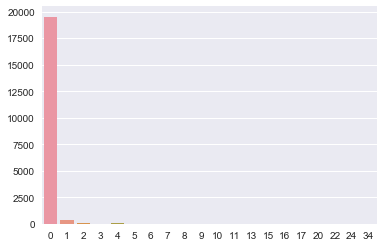

In [208]:
from collections import defaultdict


train_orig =  df_train
test_orig =  df_test
ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])
        
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

train_orig['q1_q2_intersect'] = train_orig.apply(q1_q2_intersect, axis=1, raw=True)
test_orig['q1_q2_intersect'] = test_orig.apply(q1_q2_intersect, axis=1, raw=True)

temp = train_orig.q1_q2_intersect.value_counts()
sns.barplot(temp.index[:20], temp.values[:20])

train_feat = train_orig[['q1_q2_intersect']]
test_feat = test_orig[['q1_q2_intersect']]

train = pd.DataFrame()
train["q1_q2_intersect"] = train_feat
train["is_duplicate"] = train_orig[["is_duplicate"]]
train["pid"] = train_orig[["pid"]]

test = pd.DataFrame()
test["q1_q2_intersect"] = test_feat
test["is_duplicate"] = test_orig[["is_duplicate"]]
test["pid"] = test_orig[["pid"]]

train.set_index("pid").to_csv('train_feat.csv')
print "ROC_AUC q1_q2_intersect",roc_auc_score(df_train["is_duplicate"], train_orig["q1_q2_intersect"])

test.set_index("pid").to_csv('test_feat.csv')
#print roc_auc_score(df_test["is_duplicate"], test_orig["q1_q2_intersect"])



## Rebalancing the Data
However, before I do this, I would like to rebalance the data that XGBoost receives, since we have 37% positive class in our training data, and only 17% in the test data. By re-balancing the data so our training set has 17% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [194]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()

#x_train = x[:df_train.shape[0]]
#x_test = x[df_train.shape[0]:]

x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
#x_train['tfidf_cosine_similarity'] = tfidf_train_cosine_similarity
x_train['lh_word_jaccard_containment'] = lh_word_train_jaccard_containment
x_train['rh_word_jaccard_containment'] = rh_word_train_jaccard_containment


#x_train['q1_freq'] = train_comb['q1_freq']
#x_train['q2_freq'] = train_comb['q2_freq']
#x_train['q1_q2_intersect'] = train_orig[['q1_q2_intersect']]

x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
#x_test['tfidf_cosine_similarity'] = df_test.apply(lambda row: tfidf_cosine_similarity(row, weights), axis=1, raw=True)
#x_test['word_jaccard_containment'] = df_test.apply(word_ngram_jaccard_containment, axis=1, raw=True)
x_test['lh_word_jaccard_containment'] = df_test.apply(lambda row: word_jaccard_containment(row, left=True), axis=1, raw=True)
x_test['rh_word_jaccard_containment'] = df_test.apply(lambda row: word_jaccard_containment(row, left=False), axis=1, raw=True)

#x_test['q1_freq'] = test_comb['q1_freq']
#x_test['q2_freq'] = test_comb['q2_freq']
#x_test['q1_q2_intersect'] = test_orig[['q1_q2_intersect']]

y_train = df_train['is_duplicate'].values

In [160]:
x_train.head()

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,diff_len_char,len_word_q1,len_word_q2,diff_len_word,avg_world_len1,...,diff_avg_word,exactly_same,duplicated,chrs1_len,chrs2_len,word_match,tfidf_word_match,lh_word_jaccard_containment,rh_word_jaccard_containment,svm_prediction
11904,17,12,5,14,10,4,4,3,1,3.500000,...,0.166667,0,0,10,10,0.000000,0.000000,0.000000,0.000000,NaN
6530,70,45,25,59,37,22,12,9,3,4.916667,...,0.805556,0,0,21,19,0.000000,0.000000,0.333333,0.500000,NaN
10797,30,20,10,25,17,8,6,4,2,4.166667,...,-0.083333,0,0,17,12,0.400000,0.394476,0.333333,0.500000,NaN
13230,27,43,-16,24,36,-12,4,8,-4,6.000000,...,1.500000,0,0,16,20,0.571429,0.603522,0.666667,0.500000,NaN
1249,186,70,116,151,58,93,36,13,23,4.194444,...,-0.267094,0,0,34,22,0.148148,0.150574,0.117647,0.285714,NaN


In [196]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
#p = 0.165
p = 0.149
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.166612154118


In [197]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [198]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.682596	valid-logloss:0.68265
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.596621	valid-logloss:0.597021
[20]	train-logloss:0.536789	valid-logloss:0.53753
[30]	train-logloss:0.494094	valid-logloss:0.495249
[40]	train-logloss:0.463125	valid-logloss:0.464693
[50]	train-logloss:0.440451	valid-logloss:0.442483
[60]	train-logloss:0.423774	valid-logloss:0.426274
[70]	train-logloss:0.411419	valid-logloss:0.414315
[80]	train-logloss:0.402249	valid-logloss:0.405529
[90]	train-logloss:0.395435	valid-logloss:0.399097
[100]	train-logloss:0.390372	valid-logloss:0.394444
[110]	train-logloss:0.386558	valid-logloss:0.391004
[120]	train-logloss:0.383696	valid-logloss:0.388494
[130]	train-logloss:0.381532	valid-logloss:0.386615
[140]	train-logloss:0.379921	valid-logloss:0.385338
[150]	train-logloss:0.37868	valid-logloss:0.384418
[160]	train-logloss:0.377643	va

In [200]:
d_test = xgb.DMatrix(x_test)

x_test.loc[:, "pid"] = df_test["pid"]
x_test.to_csv("x_test.csv")
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['pid'] = df_test['pid']
sub['is_duplicate'] = p_test

print('Predicted score:', log_loss(df_test['is_duplicate'], p_test))
sub.to_csv('simple_xgb.csv', index=False)

ValueError: feature_names mismatch: [u'word_match', u'tfidf_word_match', u'lh_word_jaccard_containment', u'rh_word_jaccard_containment'] [u'word_match', u'tfidf_word_match', u'lh_word_jaccard_containment', u'rh_word_jaccard_containment', u'pid']
training data did not have the following fields: pid

**0.3743** on the test set - a good first score!